In [6]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from model.VAE import *
import torch.optim as optim
# import argparse

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()

torch.manual_seed(1)
lr = 1e-3
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 100
test_batch_size = 200
x_dim = 784
latent_dim = 200
epochs = 30
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)


def loss_function(x, label, x_hat, mean, log_var, logit):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    vae_loss = reproduction_loss + KLD
    c_loss = nn.CrossEntropyLoss()(logit, label)
    beta = 0.5
    loss = vae_loss * beta + c_loss * (1 - beta) 
    return loss

def vae_loss(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    vae_loss = reproduction_loss + KLD
    return vae_loss

def train(vae_model, c_model, data_loader, vae_optimizer, c_optimizer, epoch_num):
    vae_model.train()
    c_model.train()
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        #data = data.view(batch_size, x_dim)
        data, target = data.to(device), target.to(device)
        vae_optimizer.zero_grad()
        c_optimizer.zero_grad()
        x_hat, mean, log_v, x_ = vae_model(data)
        x_cat = torch.cat((mean, log_v),1)
        logit = c_model(x_cat.detach())
        loss = loss_function(data, target, x_hat, mean, log_v, logit)
        loss_sum += loss
        loss.backward()
        # if epoch_num % 2 == 1:
        c_optimizer.step()
        vae_optimizer.step()
    return loss_sum


vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)
c_model = classifier(input_dim=256*2).to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=lr)
print(len(train_loader.dataset))
for epoch in range(1, epochs+1):
    loss = train(vae_model,c_model, train_loader, vae_optimizer, c_optimizer, epoch)
    print('Epoch {}: Average loss: {:.6f}'.format(epoch, loss/len(train_loader.dataset)))



60000


C:\Users\lovettxh\anaconda3\envs\trades\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: Average loss: 83.749184
Epoch 2: Average loss: 61.601444
Epoch 3: Average loss: 56.234550
Epoch 4: Average loss: 54.256096
Epoch 5: Average loss: 53.193581
Epoch 6: Average loss: 52.518192
Epoch 7: Average loss: 51.977318
Epoch 8: Average loss: 51.622166
Epoch 9: Average loss: 51.329758
Epoch 10: Average loss: 51.111282
Epoch 11: Average loss: 50.880417
Epoch 12: Average loss: 50.715904
Epoch 13: Average loss: 50.576344
Epoch 14: Average loss: 50.393555
Epoch 15: Average loss: 50.265739
Epoch 16: Average loss: 50.132412
Epoch 17: Average loss: 50.044930
Epoch 18: Average loss: 49.937004
Epoch 19: Average loss: 49.854034
Epoch 20: Average loss: 49.752743
Epoch 21: Average loss: 49.677803
Epoch 22: Average loss: 49.596863
Epoch 23: Average loss: 49.506741
Epoch 24: Average loss: 49.454514
Epoch 25: Average loss: 49.372513
Epoch 26: Average loss: 49.315464
Epoch 27: Average loss: 49.251003
Epoch 28: Average loss: 49.195976
Epoch 29: Average loss: 49.140484
Epoch 30: Average loss:

In [7]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].detach().cpu().numpy())

In [47]:
def model_pred(x, vae_model, c_model):
    x_hat, mean, log_v, x_ = vae_model(x)
    x_cat = torch.cat((mean, log_v), 1)
    logit = c_model(x_cat)
    return logit, mean, log_v

def testtime_update(vae_model, x_adv, learning_rate=0.1, num = 10):
    x_hat_adv, mean, log_v, x_ = vae_model(x_adv)
    x_adv = x_adv.detach()
    for _ in range(num):
        loss = vae_loss(x_adv, x_hat_adv, mean, log_v)
        mean.retain_grad()
        log_v.retain_grad()
        loss.backward(retain_graph=True)
        
        with torch.no_grad():
            mean.data -= learning_rate * mean.grad.data
            log_v.data -= learning_rate * log_v.grad.data
        mean.grad.data.zero_()
        log_v.grad.data.zero_()
        x_hat_adv = vae_model.decoder(vae_model.reparameterize(mean, log_v))

    return mean, log_v


In [48]:
def test(vae_model, c_model):
    err_num = 0
    err_adv = 0
    c_model.eval()
    vae_model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logit, _, _ = model_pred(data, vae_model, c_model)
        err_num += (logit.data.max(1)[1] != target.data).float().sum()
        x_adv = pgd(vae_model, c_model, data, target, 40, 0.3, 0.01)
        m_adv, log_adv = testtime_update(vae_model, x_adv)
        x_cat_adv = torch.cat((m_adv, log_adv), 1)
        logit_adv = c_model(x_cat_adv)
        err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
        
    print(len(test_loader.dataset))
    print(err_num)
    print(err_adv)

In [49]:
from torch.autograd import Variable
def pgd(vae_model, c_model, X, label, num_steps, epsilon, step_size):
    X_pgd = Variable(X.data, requires_grad=True)
    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()
        
        with torch.enable_grad():
            _, mean, log_v, _ = vae_model(X_pgd)
            x_cat = torch.cat((mean, log_v), 1)
            logit = c_model(x_cat)
            loss = nn.CrossEntropyLoss()(logit, label)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
    return X_pgd

In [50]:
test(vae_model, c_model)

10000
tensor(109., device='cuda:0')
tensor(6027., device='cuda:0')


In [108]:
x_hat_adv, mean, log_v, _ = vae_model(x_adv)
x_cat = torch.cat((mean, log_v), 1)
logit = c_model(x_cat)
print(logit.max(1)[1])

tensor([2, 5, 4, 7, 9, 8, 3, 4, 8, 4, 5, 5, 4, 4, 3, 3, 4, 2, 8, 9, 7, 5, 9, 2,
        9, 9, 9, 9, 5, 3, 5, 4, 5, 0, 2, 3, 2, 8, 3, 3, 8, 5, 9, 4, 5, 8, 3, 4,
        9, 8, 2, 5, 9, 8, 3, 5, 7, 8, 4, 4, 9, 3, 5, 2, 4, 5, 0, 9, 5, 5, 2, 7,
        5, 7, 8, 9, 5, 9, 4, 8, 9, 5, 4, 9, 3, 3, 8, 5, 0, 6, 9, 4, 4, 9, 2, 9,
        9, 5, 5, 4, 2, 5, 0, 9, 5, 4, 0, 8, 4, 9, 3, 1, 5, 4, 2, 9, 3, 8, 4, 8,
        9, 8, 9, 0, 4, 4, 9, 8, 3, 8, 9, 9, 8, 2, 3, 3, 9, 8, 2, 9, 3, 9, 2, 8,
        9, 3, 9, 4, 5, 9, 4, 8, 8, 8, 9, 4, 4, 9, 5, 9, 8, 5, 3, 7, 4, 3, 2, 0,
        8, 5, 9, 8, 3, 5, 3, 9, 8, 5, 8, 3, 3, 3, 8, 2, 3, 4, 3, 8, 7, 4, 8, 2,
        4, 4, 9, 8, 5, 5, 9, 3], device='cuda:0')


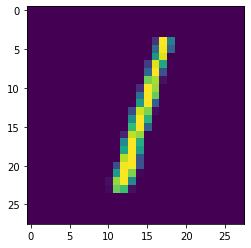

In [113]:
idex = 2
show_image(x, idx=idex)

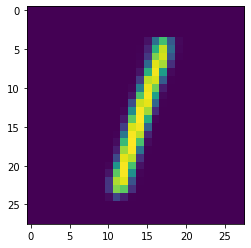

In [114]:
show_image(x_hat, idx=idex)

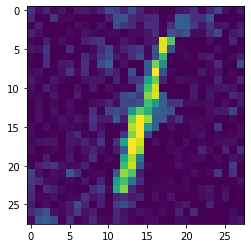

In [115]:
show_image(x_adv, idx=idex)

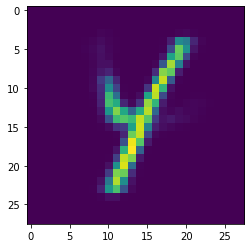

In [116]:
show_image(x_hat_adv, idx=idex)